<a href="https://colab.research.google.com/github/bsatara1/OTS-2025_26-Utjecaj_Nelinearnog_Preslusavanja_XPM_u_WDM_Sistemima/blob/main/nelinearni_XPM_u_WDM_u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalacija paketa Opticomm Py

In [ ]:
!pip install OptiCommpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.4 MB/s eta 0:00:00
  Created wheel for OptiCommpy: filename=OptiCommPy-0.10.0-py3-none-any.whl size=103552 sha256=de9057f0f17512b28e0df3735b554beebbbb70c45bbaf7d772c126256e17cb02
  Stored in directory: /root/.cache/pip/wheels/72/50/ed/2970a1406c1850c4794e38b26f6aa3a789074399841978f800
Successfully built OptiCommpy


In [ ]:
import optic
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const


In [ ]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16  # order of the modulation format
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 16  # samples per symbol
paramTx.pulseType = 'rrc' # pulse shaping filter
paramTx.nFilterTaps = 1024 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = -2 # power per WDM channel [dBm]
paramTx.nChannels = 4 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.wdmGridSpacing = 37.5e9 # WDM grid spacing
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization
paramTx.seed = 123 # random seed for bit generation

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 80     # total link distance [km]
paramCh.Lspan  = 10      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = False # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate
paramCh.seed = 456 # random seed for noise generation

# nonlinear signal propagation
sigWDM = manakovSSF(sigWDM_Tx, paramCh)

  0%|          | 0/8 [00:00<?, ?it/s]

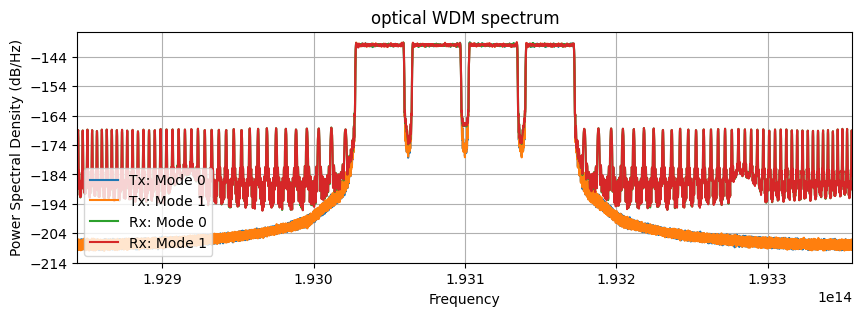

In [ ]:
# plot psd
Fs = paramCh.Fs
fig,_ = plotPSD(sigWDM_Tx, Fs, paramTx.Fc, label='Tx');
fig, ax = plotPSD(sigWDM, Fs, paramTx.Fc, fig=fig, label='Rx');
fig.set_figheight(3)
fig.set_figwidth(10)
ax.set_title('optical WDM spectrum');

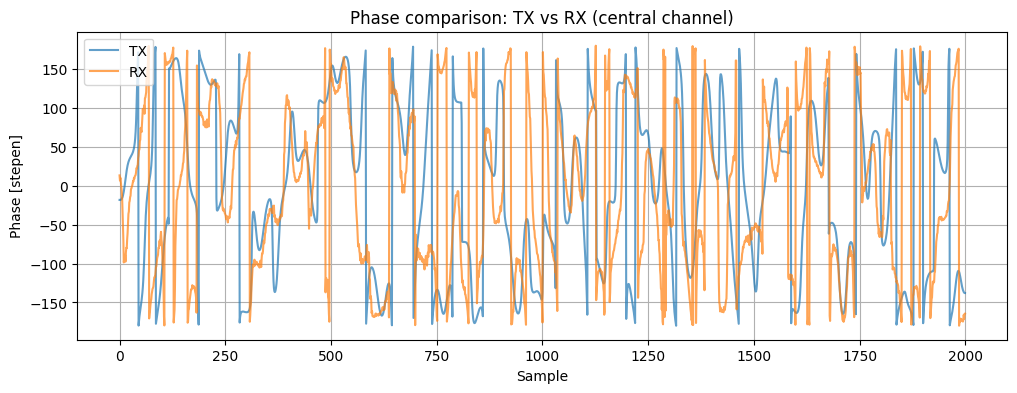

In [ ]:
center_ch = paramTx.nChannels // 2  # centralni kanal
pol = 0  # prva pol

# RX signal: iz sigWDM (poslije propagacije kroz vlakno)
victim_rx = sigWDM[:, pol]  # prvi pol, svi uzorci

# TX signal za poređenje faze: mapiraj simbole u kompleksni valni oblik
# jer sigWDM_Tx već ima upsample + filter
victim_tx = sigWDM_Tx[:, pol]

# --- Računanje faze ---
phi_tx = np.angle(victim_tx)* 180 / np.pi
phi_rx = np.angle(victim_rx)* 180 / np.pi

# --- Uporedni plot ---
plt.figure(figsize=(12,4))
plt.plot(phi_tx[:2000], label='TX', alpha=0.7)
plt.plot(phi_rx[:2000], label='RX', alpha=0.7)
plt.title("Phase comparison: TX vs RX (central channel)")
plt.xlabel("Sample")
plt.ylabel("Phase [stepen]")
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
print(phi_rx)

[ -1.21351037  -1.18104249  -4.27075094 ... -27.38487534 -26.32295979
 -26.34519286]


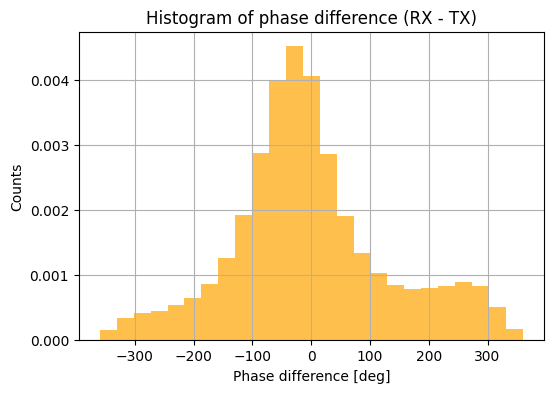

In [ ]:
# Razlika u stepenima
delta_phi_deg = (phi_rx - phi_tx)
# --- Histogram ---
plt.figure(figsize=(6,4))
plt.hist(delta_phi_deg, bins=25, color='orange', alpha=0.7 , density=True)
plt.title("Histogram of phase difference (RX - TX)")
plt.xlabel("Phase difference [deg]")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

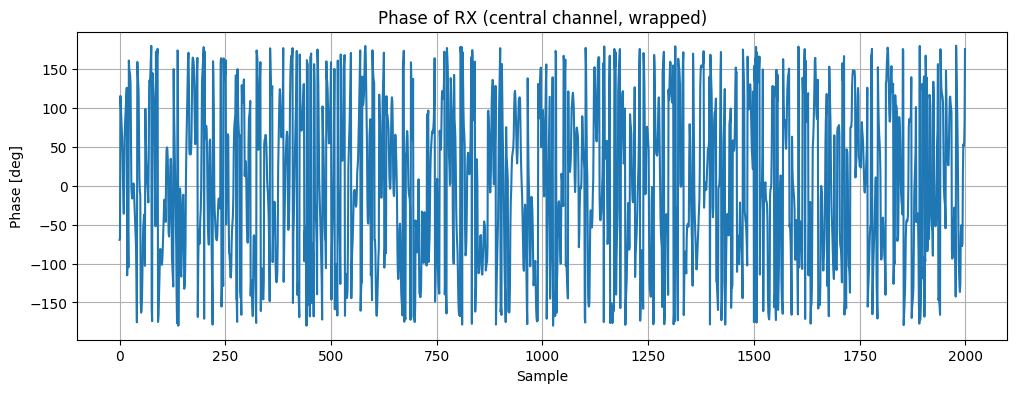

In [ ]:
phi_rx_wrapped = np.angle(victim_rx)  # u radijanima
phi_rx_deg = phi_rx_wrapped * 180 / np.pi

plt.figure(figsize=(12,4))
plt.plot(phi_rx_deg[:2000])
plt.title("Phase of RX (central channel, wrapped)")
plt.xlabel("Sample")
plt.ylabel("Phase [deg]")
plt.grid(True)
plt.show()
